In [2]:
import os
import json
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
import jax.numpy as jnp

import sys
sys.path.append('../')

from environment.maze import MetaMaze

jax.device_count(), jax.devices()

(1, [cuda(id=0)])

## Visualize training curves

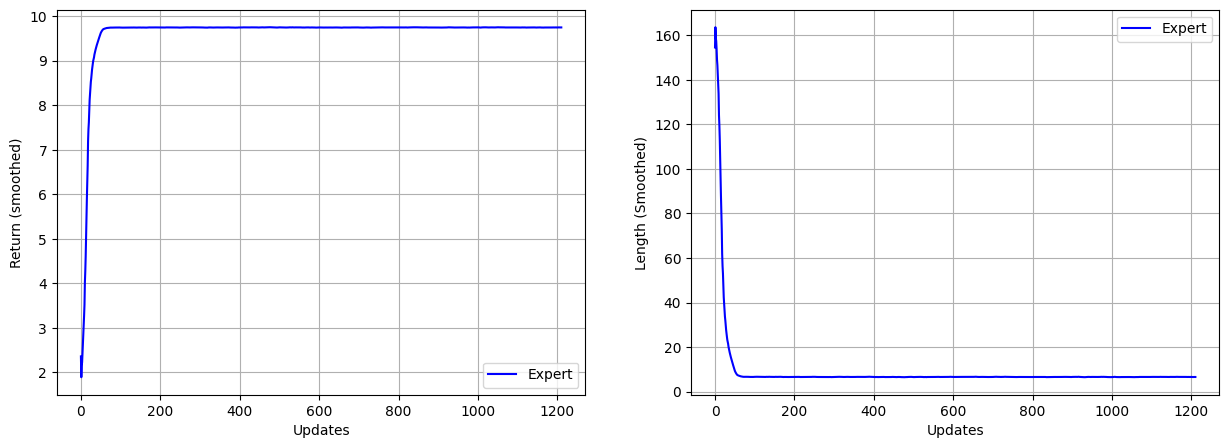

In [23]:
log = 'logs_rl'
load_path = f'/data/draco/cleain/imitation_gap_minigrid/{log}'
expe_num='20231214_190953'
n_epochs = 4

with open(os.path.join(load_path, expe_num, 'args.json'), 'r') as file:
    config = json.load(file)

label = 'Expert' if config['is_expert'] else 'Imitator'
color = 'b' if config['is_expert'] else 'm'

metric_path = os.path.join(load_path, expe_num, f'training_metrics_{n_epochs}.pkl')

import pickle
# Load the data from the pickle file
with open(metric_path, 'rb') as f:
    out = pickle.load(f)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
window_size = 10

fig.add_subplot(1,2,1)
smoothed_return = jnp.convolve(out['r'].reshape(-1),
                               jnp.ones(window_size) / window_size,
                               mode='valid')

plt.plot(smoothed_return, label=label, c=color)
plt.xlabel("Updates")
plt.ylabel("Return (smoothed)")
plt.legend()
plt.grid('on')

smoothed_length = jnp.convolve(out['l'].reshape(-1),
                               jnp.ones(window_size) / window_size,
                               mode='valid')

fig.add_subplot(1,2,2)
plt.plot(smoothed_length, label=label, c=color)
plt.xlabel("Updates")
plt.ylabel("Length (Smoothed)")
plt.grid('on')
plt.legend();


## Visualize learned policy

In [3]:
from IPython.display import clear_output
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt
from PIL import Image
import pickle

In [16]:
from model.rnn_policy import ScannedRNN, ActorCriticRNN
import json

expe_num = '20231207_131924'
log = 'logs_bc'
epochs = '100'

with open(f'/data/draco/cleain/imitation_gap_minigrid/{log}/{expe_num}/args.json', 'r') as file:
    config = json.load(file)

with open(f'/data/draco/cleain/imitation_gap_minigrid/{log}/{expe_num}/params_{epochs}.pkl', 'rb') as file:
    params = pickle.load(file)

In [17]:
def plot_grid_on_image(axe, img, grid_size=(10, 10)):

    # Define grid parameters
    rows, cols = img.shape[:2]

    # Plot vertical grid lines
    for i in range(1, rows + 1):
        axe.axvline(x=1 * i - 0.5, color='gray', linewidth=0.5)

    # Plot horizontal grid lines
    for j in range(1, cols + 1):
        axe.axhline(y=1 * j - 0.55, color='gray', linewidth=0.5)

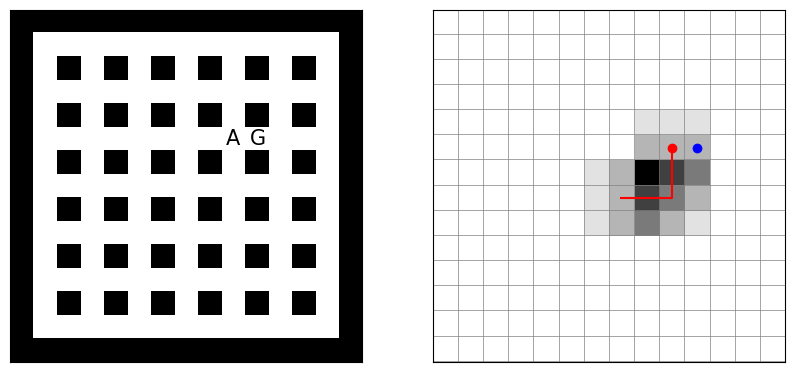

In [28]:
tt = 0
imgs = []

import numpy as np
occupancy = np.zeros((14, 14))
all_pos = []

rng = jax.random.PRNGKey(7)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

env = MetaMaze(**config['params'])
env_params = env.default_params

network = ActorCriticRNN(env.action_space(env_params).n)

obs, env_state = env.reset(key_reset, env_params)
done = False
hstate = ScannedRNN.initialize_carry((1, 128))

while not done and tt < 200:

    all_pos.append(env_state.pos)
    occupancy[env_state.pos[0] - env.rf_off : env_state.pos[0] + env.rf_off + 1,
              env_state.pos[1] - env.rf_off : env_state.pos[1] + env.rf_off + 1] += 1

    # occupancy[env_state.pos[0],
            #   env_state.pos[1]] += 1

    # fig, ax = env.render(env_state, env_params)
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    ax[0].imshow(env.occupied_map, cmap="Greys")
    ax[0].annotate(
        "A",
        fontsize=15,
        xy=(env_state.pos[1], env_state.pos[0]),
        xycoords="data",
        xytext=(env_state.pos[1] - 0.3, env_state.pos[0] + 0.25),
    )
    ax[0].annotate(
        "G",
        fontsize=15,
        xy=(env_state.goal[1], env_state.goal[0]),
        xycoords="data",
        xytext=(env_state.goal[1] - 0.3, env_state.goal[0] + 0.25),
    )
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # fig.add_subplot(1,2,2)
    ax[1].imshow(occupancy, vmin=0, vmax=5, cmap="Greys")
    plot_grid_on_image(ax[1], occupancy)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    if len(all_pos) > 0:
        ax[1].plot(jnp.array(all_pos)[:, 1], jnp.array(all_pos)[:, 0], c='r')
    ax[1].scatter(all_pos[-1][1], all_pos[-1][0], c='r')
    ax[1].scatter(env_state.goal[1], env_state.goal[0], c='b')

    plt.show()

    rng, _rng = jax.random.split(rng)

    # SELECT ACTION
    ac_in = (obs[jnp.newaxis,jnp.newaxis, :], jnp.array([done])[jnp.newaxis,jnp.newaxis, :])
    hstate, pi, value = network.apply(params, hstate, ac_in)
    action = pi.sample(seed=_rng)
    log_prob = pi.log_prob(action)
    value, action, log_prob = (
        value.squeeze(0),
        action.squeeze(0),
        log_prob.squeeze(0),
    )

    # STEP ENV
    rng, _rng = jax.random.split(rng)

    # Update the environment
    _, env_state, reward, done, info = env.step(_rng, env_state, action[0], env_params)

    # Get the observation
    # obs = env.get_obs(env_state, env_params, config['is_expert'])
    obs = env.get_obs(env_state, env_params, False)

    tt += 1
    
    canvas = FigureCanvasAgg(fig)
    canvas.draw()

    # Get the image buffer as a PIL image
    pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
    imgs.append(pil_image)

    clear_output(wait=True)


In [35]:
# Save gif
gif_file = f"../animation/{expe_num}/ex_{key_reset[0]}.gif"
os.makedirs(f"../animation/{expe_num}", exist_ok=True)

imgs[0].save(gif_file, save_all=True, append_images=imgs, duration=100, loop=0)

## Baselines

In [35]:
expert_expe_num = '20231214_190953'
expert_logs = 'logs_rl'

limited_agent_expe_num = '20231214_171043'
limited_agent_logs = 'logs_rl'

with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', expert_logs, expert_expe_num, 'eval_500.json'), 'r') as file:
    expert_metrics = json.load(file)
expert_mean = jnp.array(expert_metrics['l']).mean()
expert_std = jnp.array(expert_metrics['l']).std()
expert_n = len(expert_metrics['l'])

with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', limited_agent_logs, limited_agent_expe_num, 'eval_500.json'), 'r') as file:
    limited_agent_metrics = json.load(file)
limited_agent_mean = jnp.array(limited_agent_metrics['l']).mean()
limited_agent_std = jnp.array(limited_agent_metrics['l']).std()
limited_agent_n = len(limited_agent_metrics['l'])

In [36]:
jnp.array(expert_metrics['l']).mean()

Array(6.6119637, dtype=float32)

In [189]:
def plot_imitator(imitator_expe_num, imitator_logs, imitator_n_epochs, window_size=10):
    with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', imitator_logs, imitator_expe_num, 'args.json'), 'r') as file:
        imitator_config = json.load(file)

    with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', 'logs_rl', imitator_config['expert_expe_num'], 'args.json'), 'r') as file:
        teacher_config = json.load(file)

    with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', imitator_logs, imitator_expe_num, 'eval_100.json'), 'r') as file:
        imitator_eval_metrics = json.load(file)

    with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', imitator_logs, imitator_expe_num, f'training_metrics_{imitator_n_epochs}.pkl'), 'rb') as file:
        imitator_training_metrics = pickle.load(file)

    print(f"Imitator: \n \
        BC from: {imitator_config['expert_expe_num']} \n \
        Has full_obs: {imitator_config['full_obs']} \n \
        Mean length eval: {jnp.array(imitator_eval_metrics['l']).mean():.4f} \n \
        Mean return eval: {jnp.array(imitator_eval_metrics['r']).mean():.4f}")

    if (teacher_config['is_expert'] and imitator_config['full_obs']):
        label = 'Imitator (full obs) from expert (full obs)'
        color = 'darkturquoise'
    elif (teacher_config['is_expert'] and not imitator_config['full_obs']):
        label = 'Imitator (limited obs) from expert (full obs)'
        color = 'orange'
    elif (not teacher_config['is_expert'] and not imitator_config['full_obs']):
        label = 'Imitator (limited obs) from expert (limited obs)'
        color = 'darkred'

    # Imitator performance
    data = [
        imitator_training_metrics[i]['validation']['returned_episode_lengths'][
            imitator_training_metrics[i]['validation']['returned_episode']
        ].mean()
        for i in range(imitator_n_epochs)
    ]

    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')  # Example moving average

    plt.plot(smoothed_data, label=label, color=color)

Imitator: 
         BC from: 20231205_100708 
         Has full_obs: False 
         Mean length eval: 160.0099 
         Mean return eval: 2.0792
Imitator: 
         BC from: 20231201_113014 
         Has full_obs: False 
         Mean length eval: 37.3755 
         Mean return eval: 9.9127
Imitator: 
         BC from: 20231205_100708 
         Has full_obs: True 
         Mean length eval: 6.5533 
         Mean return eval: 10.0000


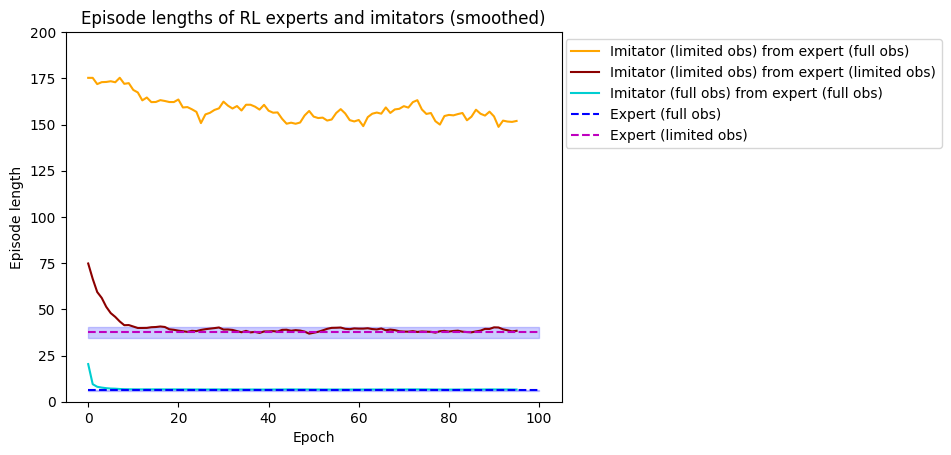

In [190]:
N = 100

# Imitators
plot_imitator('20231207_131924', 'logs_bc', N, window_size=5)
plot_imitator('20231207_120509', 'logs_bc', N, window_size=5)
plot_imitator('20231207_120449', 'logs_bc', N, window_size=5)

# Expert performance
plt.plot([0, N], [expert_mean] * 2, ls='--', label='Expert (full obs)', color='b')
plt.fill_between([0, N], 
                 [expert_mean - 1.96 * expert_std / jnp.sqrt(expert_n)] * 2, 
                 [expert_mean + 1.96 * expert_std / jnp.sqrt(expert_n)] * 2, alpha=0.2, color='b')

# RL agent performance
plt.plot([0, N], [limited_agent_mean] * 2, ls='--', label='Expert (limited obs)', color='m')
plt.fill_between([0, N], 
                 [limited_agent_mean - 1.96 * limited_agent_std / jnp.sqrt(limited_agent_n)] * 2, 
                 [limited_agent_mean + 1.96 * limited_agent_std / jnp.sqrt(limited_agent_n)] * 2, alpha=0.2, color='b')

plt.ylabel('Episode length')
plt.xlabel('Epoch')
plt.title('Episode lengths of RL experts and imitators (smoothed)')
plt.ylim(0, 200)

plt.legend(bbox_to_anchor=(1.78, 1));

## Visualize state visiting map

In [27]:
import pickle
import matplotlib.pyplot as plt

with open('/data/draco/cleain/imitation_gap_minigrid/logs_rl/20231214_190953/visiting_500.pkl', 'rb') as file:
    expert_visiting_state = pickle.load(file)

expert_visiting_state.shape

(15, 15)

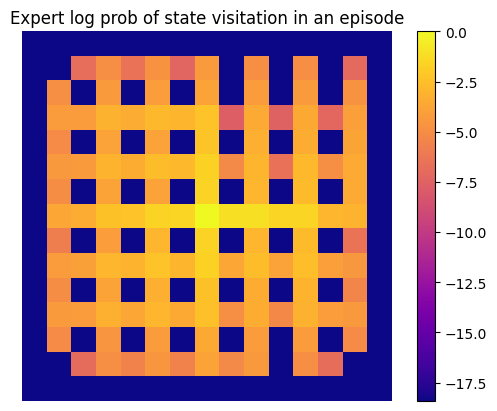

In [28]:
# plt.imshow(1 - env.occupied_map, cmap='gray')
plt.imshow(jnp.log(expert_visiting_state / jnp.max(expert_visiting_state) + 1e-8), cmap='plasma')
plt.colorbar()
plt.title('Expert log prob of state visitation in an episode')
plt.axis('off');